In [1]:
1


1

In [ ]:
!wget http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_Dataset.zip

In [ ]:
!unzip Flickr8k_Dataset.zip

In [ ]:
!wget http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_text.zip

In [ ]:
!unzip Flickr8k_text.zip

In [2]:
import pandas as pd

data = pd.read_csv('./Flickr8k.token.txt', sep='\t', header=None)

In [3]:
data.head()

,0,1
0,1000268201_693b08cb0e.jpg#0,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg#1,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg#2,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg#3,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg#4,A little girl in a pink dress going into a woo...


In [4]:
len(data)

40460

In [5]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [6]:
from collections import defaultdict

img_to_captions = defaultdict(list)

for img, caption in data.values:
    img = './Flicker8k_Dataset/' + img.split('#')[0]
    img_to_captions[img] += [caption]

['A dog and his owner at a rocky beach .', 'A man and a dog on rocks on a beach .', 'A man and dog on a rocky seashore .', 'A person is walking their brown dog over large rocks near the ocean .', 'Man and dog standing on rocks next to water']


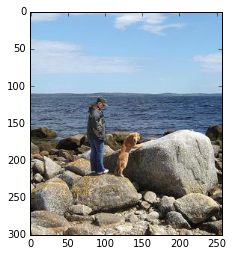

In [7]:
print img_to_captions.values()[0]
img = plt.imread(img_to_captions.keys()[0])
plt.imshow(img)

In [8]:
import PIL
from tqdm import tnrange as prange, tqdm_notebook as pbar

In [ ]:
corrupted = []

for path in pbar(img_to_captions.keys()):
    try:
        i = PIL.Image.open(path)
        i.thumbnail((300, 300))
        i.save(path)
    except:
        corrupted.append(path)

In [ ]:
len(corrupted)

In [ ]:
img_to_captions.pop(corrupted[0])

['A dog and his owner at a rocky beach .', 'A man and a dog on rocks on a beach .', 'A man and dog on a rocky seashore .', 'A person is walking their brown dog over large rocks near the ocean .', 'Man and dog standing on rocks next to water']


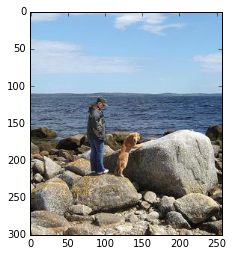

In [9]:
print img_to_captions.values()[0]
img = plt.imread(img_to_captions.keys()[0])
plt.imshow(img)

## пожали, но что поделать))

In [10]:
import numpy as np
import tensorflow as tf
import os
from tensorflow.python.platform import gfile
import os.path
import re
import sys
import tarfile
from subprocess import Popen, PIPE, STDOUT
import cPickle as pickle
from PIL import Image
import requests
import wget

In [11]:
#загружаем модель
with open('/home/alaktionov/alaktionov_oneshots/notebooks/phash_streaming/node_lookup.pk1','rb') as f:
    node_lookup=pickle.load(f)
    
with open('/home/alaktionov/alaktionov_oneshots/notebooks/phash_streaming/model_data.pk1','rb') as f:
    model_data=pickle.load(f)
    

In [11]:
import argparse
from raven import Client 


In [12]:
#def apply_batch(batch):
#  with tf.Graph().as_default() as g:
graph_def = tf.GraphDef()
graph_def.ParseFromString(model_data)
tf.import_graph_def(graph_def, name='')

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
sess=tf.Session(config=tf.ConfigProto(log_device_placement=True, gpu_options=gpu_options))# as sess:
  #labelled = [run_image(sess, img_id, img_url, node_lookup) for (img_id, img_url) in batch]
          #return [tup for tup in labelled if tup[2] is not None]

#sess=tf.Session(config=tf.ConfigProto(log_device_placement=True)) 
raven_client=Client('http://######@sentry.cian.ru/20')


In [13]:
def run_image(path):

    raven_client.user_context({
        'path': path
    })

#     try:
    image_data = tf.gfile.FastGFile(path).read()
#     except:
#         raven_client.captureException()

    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
#     try:
    predictions = sess.run(softmax_tensor,
                           {'DecodeJpeg/contents:0': image_data})
#     except:
#         raven_client.captureException()
#         os.remove(real_url)
#         return (img_id, img_url, None)

    predictions = np.squeeze(predictions)
    return predictions
#     top_k = predictions.argsort()[-num_top_predictions:][::-1]
#     scores = []
#     for node_id in top_k:
#     if node_id not in node_lookup:
#         human_string = ''
#     else:
#         human_string = node_lookup[node_id]
#     score = predictions[node_id]
#     scores.append((human_string, score))

#     os.remove(real_url)

#     return (img_id, img_url, scores)


In [14]:
test_v = run_image(img_to_captions.keys()[0])

In [15]:
test_v.shape

(1008,)

## ну тоже примерно косарь

In [18]:
im2vec = {}
for path in pbar(img_to_captions.keys()):
    vec = run_image(path)
    if path not in im2vec:
        im2vec[path] = vec
    else:
        print 'collision!'
        break

In [17]:
len(im2vec)

7657

In [25]:
vecs, captions = [], []
for path, vec in im2vec.items():
    vecs += ['\t'.join(map(str, vec))]
    captions += ['\t'.join(img_to_captions[path])]
#     vec_to_captions[tuple(vec)] = img_to_captions[path]

In [26]:
df = pd.DataFrame([v,c] for v,c in zip(vecs, captions))
df.columns = ['vec', 'captions']
df.head()

,vec,captions
0,4.02434e-05\t3.3467e-05\t0.00180185\t0.0007248...,A dog and his owner at a rocky beach .\tA man ...
1,2.37338e-08\t1.57906e-08\t7.32941e-09\t1.58538...,A girl in a white coat stands in the middle of...
2,0.000185481\t3.87513e-05\t0.00461234\t0.000105...,a black and white dog jumping in the air while...
3,0.000255933\t0.000194344\t6.48758e-05\t0.00261...,Dogs race on a track .\tDogs racing at the rac...
4,0.000313871\t0.000280793\t0.000523617\t0.00030...,A child wearing swim goggles .\tA small child ...


In [27]:
df.to_csv('inception_vecs_capts.dogsv', sep='@')

In [16]:
img = PIL.Image.open('./data/Dog-and-Cat.jpg')
img.thumbnail((300,300))
img.save('./data/Dog-and-Cat_thumb.jpg')

In [17]:
vec = run_image('./data/Dog-and-Cat_thumb.jpg')

In [18]:
vec.shape

(1008,)

In [23]:
with open('dogandcat.txt', 'w') as f:
    for v in vec:
        f.write(str(v) + '\n')

In [22]:
!rm dogandcat.txt